<h1>Chapter 6 - Prompt Engineering</h1>
<i>Methods for improving the output through prompt engineering.</i>

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961"><img src="https://img.shields.io/badge/Buy%20the%20Book!-grey?logo=amazon"></a>
<a href="https://www.oreilly.com/library/view/hands-on-large-language/9781098150952/"><img src="https://img.shields.io/badge/O'Reilly-white.svg?logo=data:image/svg%2bxml;base64,PHN2ZyB3aWR0aD0iMzQiIGhlaWdodD0iMjciIHZpZXdCb3g9IjAgMCAzNCAyNyIgZmlsbD0ibm9uZSIgeG1sbnM9Imh0dHA6Ly93d3cudzMub3JnLzIwMDAvc3ZnIj4KPGNpcmNsZSBjeD0iMTMiIGN5PSIxNCIgcj0iMTEiIHN0cm9rZT0iI0Q0MDEwMSIgc3Ryb2tlLXdpZHRoPSI0Ii8+CjxjaXJjbGUgY3g9IjMwLjUiIGN5PSIzLjUiIHI9IjMuNSIgZmlsbD0iI0Q0MDEwMSIvPgo8L3N2Zz4K"></a>
<a href="https://github.com/HandsOnLLM/Hands-On-Large-Language-Models"><img src="https://img.shields.io/badge/GitHub%20Repository-black?logo=github"></a>
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HandsOnLLM/Hands-On-Large-Language-Models/blob/main/chapter06/Chapter%206%20-%20Prompt%20Engineering.ipynb)

---

This notebook is for Chapter 6 of the [Hands-On Large Language Models](https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961) book by [Jay Alammar](https://www.linkedin.com/in/jalammar) and [Maarten Grootendorst](https://www.linkedin.com/in/mgrootendorst/).

---

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961">
<img src="https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/images/book_cover.png" width="350"/></a>

### [OPTIONAL] - Installing Packages on <img src="https://colab.google/static/images/icons/colab.png" width=100>

If you are viewing this notebook on Google Colab (or any other cloud vendor), you need to **uncomment and run** the following codeblock to install the dependencies for this chapter:

---

💡 **NOTE**: We will want to use a GPU to run the examples in this notebook. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---


# 第六章 提示工程

##### 知识点回顾

- 在上章中，我们探讨了生成式和表征式大语言模型（LLMs）如何在无监督学习领域中得到应用。
- 常见的文本文档聚类流程：首先从将输入文本转换为数值表示开始，我们称之为嵌入。然后，对这些嵌入进行降维处理，以简化高维数据，从而获得更好的聚类结果。最后，对降维后的嵌入应用聚类算法，对输入文本进行聚类。通过手动检查聚类结果，我们了解了每个聚类包含哪些文档，以及如何解释这些聚类。
- 为了摆脱这种手动检查的方式，我们探讨了BERTopic如何通过一种自动表示聚类的方法扩展了文本聚类流程。这种方法通常被称为主题建模，它试图揭示大量文档中的主题。BERTopic通过结合c-TF-IDF增强的词袋方法生成这些主题表示，该方法根据单词在所有聚类中的相关性和频率对单词进行加权。
- BERTopic的一个主要优点是它的模块化特性。在BERTopic中，您可以选择流程中的任何模型，这允许对主题进行额外的表示，从而创建同一主题的多个视角此外，我们还使用了生成式大型语言模型（Flan-T5和GPT-3.5）来生成高度可解释的标签，从而进一步提高主题的可解释性。
- 在本章中，我们将更详细地探索这些生成式模型，并深入提示工程、基于生成式模型的推理、验证，甚至对其输出进行评估的领域。

## 使用文本生成模型

- 如何选择要使用的模型？
- 使用专有模型还是开源模型？
- 如何控制生成的输出？

### 选择文本生成模型

- 第一步是在专有模型和开源模型之间进行选择。

下图展示了一小部分有影响力的基础模型，这些大型语言模型（LLMs）已经在大量文本数据上进行了预训练，并且经常针对特定应用进行微调。

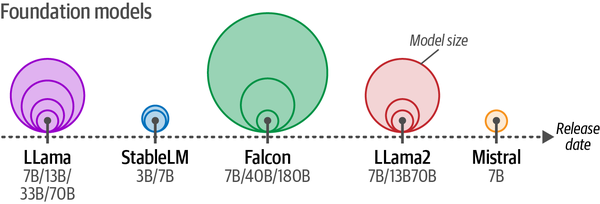

基于这些基础模型，已经对数百甚至数千个模型进行了微调，每个模型都比另一个更适合某些任务。选择要使用哪个模型可能是一项艰巨的任务！

我们建议先从小型基础模型开始。小型模型为入门提供了很好的基础，并为过渡到更大规模的模型奠定了坚实的基础。

### 加载文本生成模型

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# 加载模型和分词器
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

# 创建一个流程
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    max_new_tokens=500,
    do_sample=False,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


与前几章相比，我们将更深入地探讨开发和使用提示模板。

In [ ]:
# 提示
messages = [
    {"role": "user", "content": "Create a funny joke about chickens."}
]

# 生成输出
output = pipe(messages)
print(output[0]["generated_text"])

在内部，transformers.pipeline首先将我们的消息转换为特定的提示模板。我们可以通过访问底层的分词器来探索这个过程：

In [ ]:
# 应用提示模板
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False)
print(prompt)

<s><|user|>
Create a funny joke about chickens.<|end|>
<|assistant|>



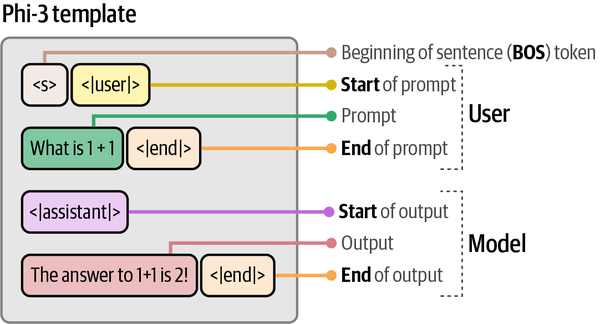

### 控制模型输出

除了提示工程之外，我们还可以通过调整模型参数来控制我们想要的输出类型，包括temperature和top_p，这些参数控制输出的随机性。

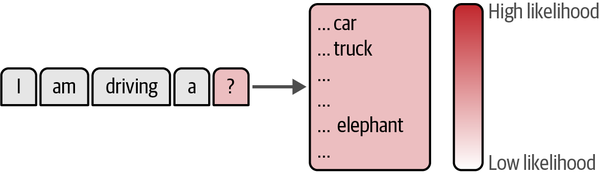

加载模型时，do_sample = False，以确保输出具有一定的一致性。为了使用temperature和top_p参数，我们将设置do_sample = True以便利用它们。

#### Temperature

- 控制着生成文本的随机性或创造性
- 决定了选择不太可能的标记的可能性有多大
- 当temperature为0时，每次都会生成相同的响应，因为它总是选择最可能的单词。

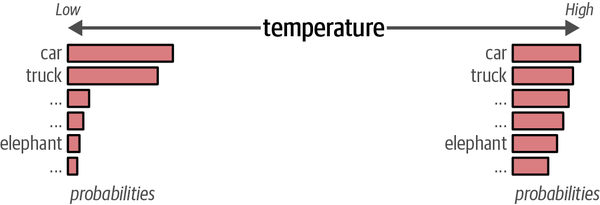

In [ ]:
# 使用一个高temperature
output = pipe(messages, do_sample=True, temperature=1)
print(output[0]["generated_text"])

 Why don't chickens ever play hide and seek? Because good luck hiding when everyone always goes to the henhouse!


#### top_p

- 也被称为核采样，是一种采样技术，用于控制大型语言模型（LLM）可以考虑的标记（即核）的子集
- 考虑标记，直到达到这些标记的累积概率
- 如果我们将top_p设置为1，它将考虑所有标记

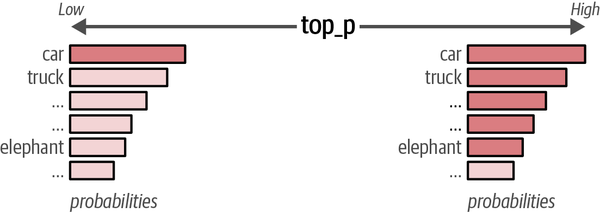

同样地，top_k参数精确控制大型语言模型（LLM）可以考虑多少个标记。如果您将其值更改为100，LLM将仅考虑前100个最可能的标记。

In [ ]:
# 使用一个高top_p
output = pipe(messages, do_sample=True, top_p=1)
print(output[0]["generated_text"])

 Why don't chickens like math class? Because they can't solve for "x" in their eggs!


如表所示，这些参数允许用户在创造性（高temperature和高top_p值）和可预测性（低temperature和低top_p值）之间有一个滑动尺度。

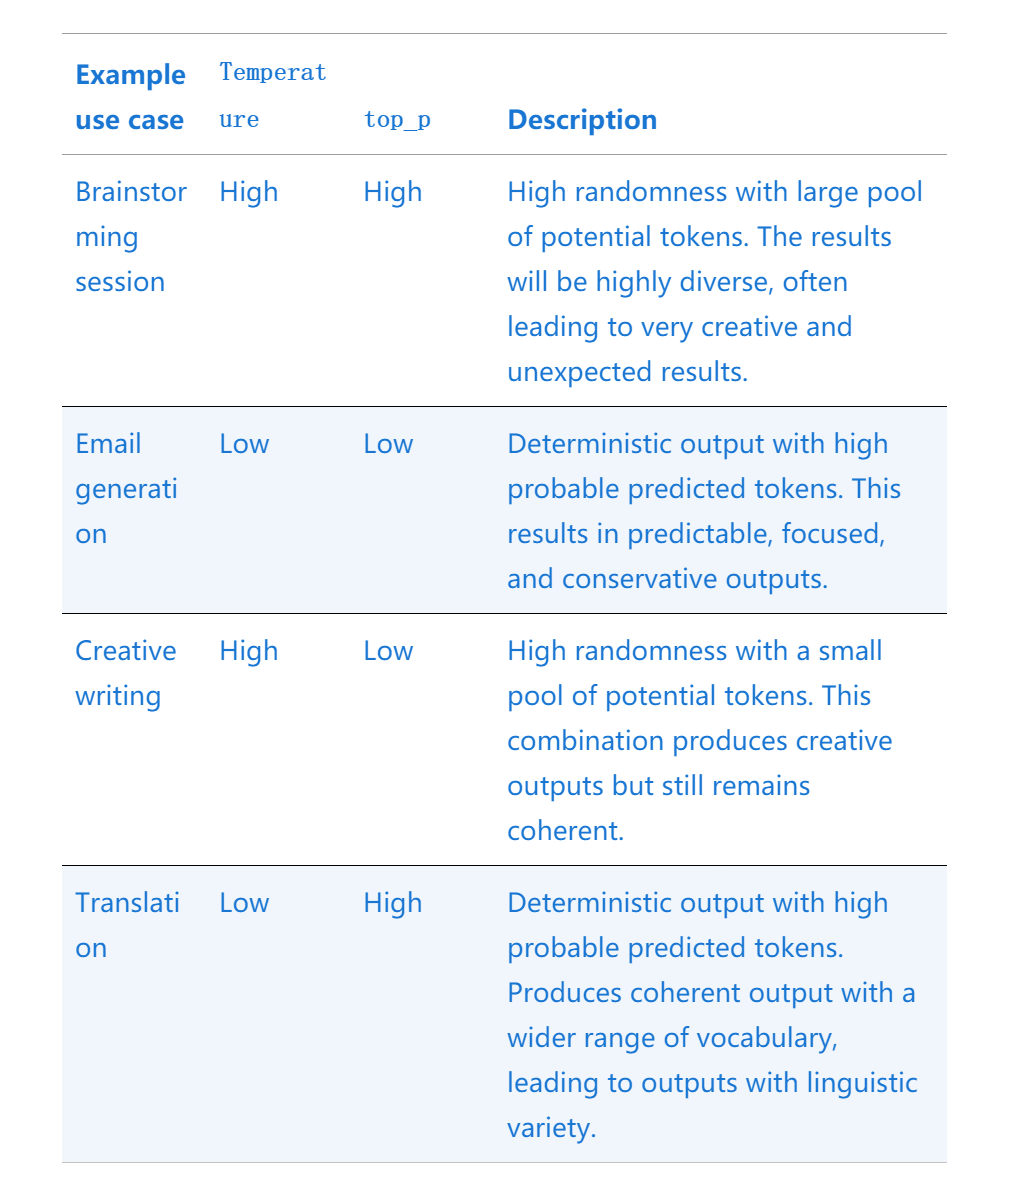

## 提示工程简介

- 主要目标：激发模型给出有用的回复
- 不仅仅是设计有效的提示，还可以用作评估模型输出以及设计保障措施和安全缓解方法的工具

在本节中，我们将介绍提示工程的常见方法，以及一些了解特定提示效果的小贴士和技巧。首先回答这样一个问题：提示中应该包含什么？

### 提示的基本要素

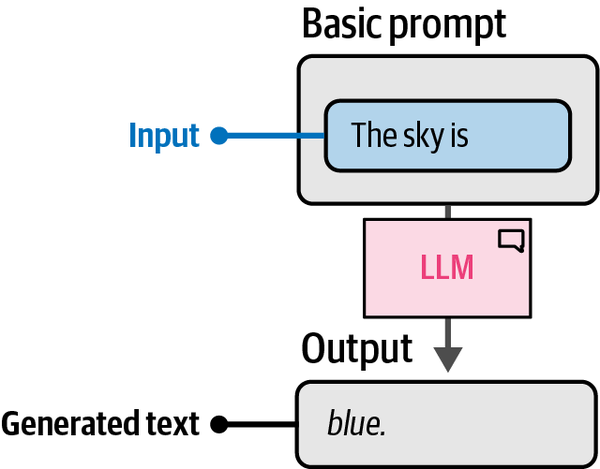

这是提示的一个基本示例。没有给出任何指令，所以大型语言模型（LLM）将只是尝试完成句子，但它无法完成特定的任务。相反，我们通常通过提出LLM应该完成的特定问题或任务来进行提示工程。为了激发所需的回应，我们需要一个更有结构的提示。

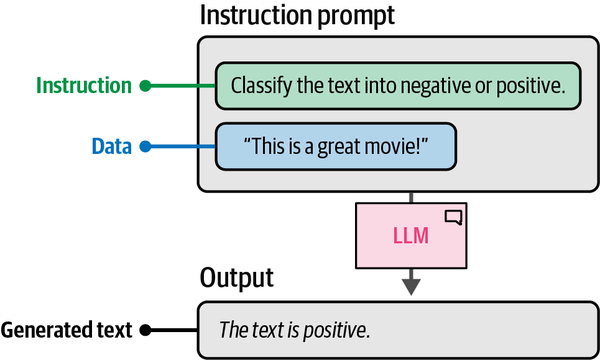

如图，我们可以要求大型语言模型（LLM）将句子分类为正面或负面情感。这将最基本的提示结构，由两个部分组成——指令本身和与指令相关的数据。

更复杂的用例可能需要在提示中包含更多组件。例如，为了确保模型只输出“负面”或“正面”，我们可以引入输出指示符来帮助引导模型。

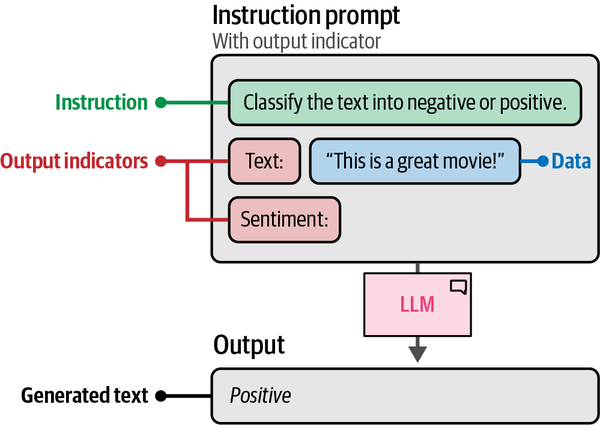

我们可以继续添加或更新提示的元素，直到我们得到想要的回应。我们可以添加更多示例，更详细地描述用例，提供额外上下文等。设计这些组件时所需的创造力是关键。

### 基于指令的提示

- 让LLM回答特定问题或解决特定任务

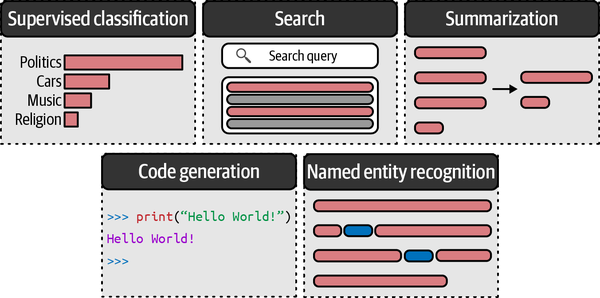

这些任务中的每一个都需要不同的提示格式，更具体地说，需要向大型语言模型（LLM）提出不同的问题。

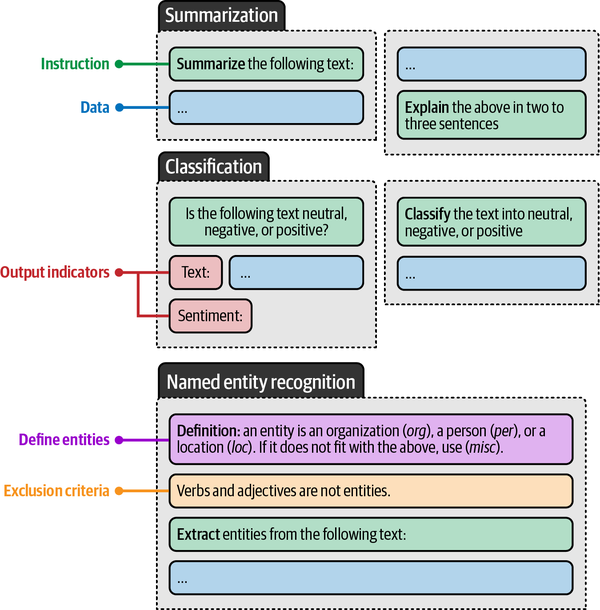

尽管这些任务需要不同的指令，但在提高输出质量的提示技术方面实际上有很多重叠。这些技术的不完全列表包括：

- 具体性：准确描述你想要实现的目标。不要要求大型语言模型（LLM）“为产品编写描述”，而是要求它“用两句话以内且使用正式语气为产品编写描述”。
- 避免幻觉：LLM可能会自信地生成错误信息，这被称为幻觉。为了减少其影响，我们可以要求LLM只有在知道答案时才生成答案。如果它不知道答案，可以回复“我不知道”。
- 顺序：在提示的开头或结尾给出指令。特别是对于长提示，中间的信息往往会被遗忘。LLM往往关注提示开头的信息（首因效应）或提示结尾的信息（近因效应）。

特异性是最重要的方面。通过限制和明确规定模型应该生成的内容，可以大大降低它生成与您的用例无关内容的风险。

## 高级提示工程

- 表面上看，创建一个好的提示似乎很简单
- 提示往往是一个被低估的组成部分

从构建复杂提示的迭代工作流程开始，一直到顺序使用大型语言模型以获得更好的结果。最终，我们甚至将构建到高级推理技巧。

### 提示的潜在复杂性

在提示工程简介中，我们探讨了提示通常包含多个组成部分。在我们的第一个示例中，我们的提示由指令、数据和输出指示器组成。但提示不仅限于这三个组成部分，我们可以根据需要将其构建得尽可能复杂。这些高级组成部分会迅速使提示变得相当复杂。一些常见组成部分包括：

- 角色设定（Persona）：描述大型语言模型（LLM）应该扮演的角色。例如，如果您想询问一个关于天体物理学的问题，可以使用“你是天体物理学专家”这样的角色设定。
- 指令（Instruction）：任务本身。确保这一指令尽可能具体。我们不希望留下太多解释的空间。
- 背景（Context）：描述问题或任务背景的额外信息。它回答了诸如“为什么需要这个指令？”之类的问题。
- 格式（Format）：大型语言模型在输出生成的文本时应使用的格式。如果没有指定格式，大型语言模型会自行决定格式，这在自动化系统中会造成麻烦。
- 受众（Audience）：生成文本的目标对象。这也描述了生成输出的水平。在教育目的下，使用ELI5（“像五岁小孩一样解释”）通常很有帮助。
- 语气（Tone）：大型语言模型（LLM）在生成文本中应使用的语气。如果您正在给老板写一封正式邮件，您可能不希望使用非正式的语气。
- 数据（Data）：与任务本身相关的主要数据。

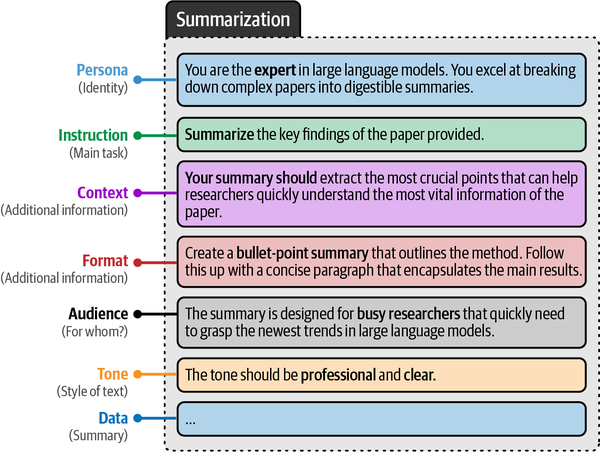

这个复杂的提示展示了提示的模块化特性。我们可以自由地添加和删除组件，并判断它们对输出的影响。

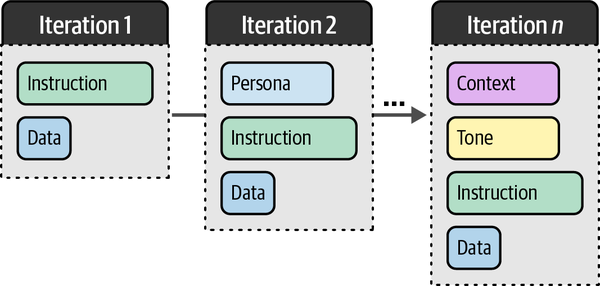

这些更改不仅限于简单地引入或删除组件。正如我们之前看到的近因效应和首因效应所示，它们的顺序也会影响大型语言模型（LLM）输出的质量。换句话说，在为您的使用场景找到最佳提示时，实验至关重要。通过提示，我们基本上使自己处于实验迭代的循环中。

In [ ]:
# Prompt components
persona = "You are an expert in Large Language models. You excel at breaking down complex papers into digestible summaries.\n"
instruction = "Summarize the key findings of the paper provided.\n"
context = "Your summary should extract the most crucial points that can help researchers quickly understand the most vital information of the paper.\n"
data_format = "Create a bullet-point summary that outlines the method. Follow this up with a concise paragraph that encapsulates the main results.\n"
audience = "The summary is designed for busy researchers that quickly need to grasp the newest trends in Large Language Models.\n"
tone = "The tone should be professional and clear.\n"
text = "MY TEXT TO SUMMARIZE"
data = f"Text to summarize: {text}"

# The full prompt - remove and add pieces to view its impact on the generated output
query = persona + instruction + context + data_format + audience + tone + data

##### Tip

- 我们可以添加各种各样的组件，以及创新的组件，比如使用情感刺激（例如，“这对我的职业生涯非常重要。”）。提示工程的乐趣之一在于，你可以尽可能地发挥创意，找出哪些提示组件的组合对你的用例有帮助。在开发适合你的格式时，几乎没有什么限制。
- 在某种程度上，这是在尝试逆向工程模型所学的内容以及它如何对某些提示做出响应。然而，请注意，与其他模型相比，某些提示在某些模型上效果更好，因为它们的训练数据可能不同，或者它们的训练目的不同。

### 情境学习：提供示例

- 与其描述任务，为什么不直接展示任务呢？
- 为LLM提供我们想要实现的精确目标的示例

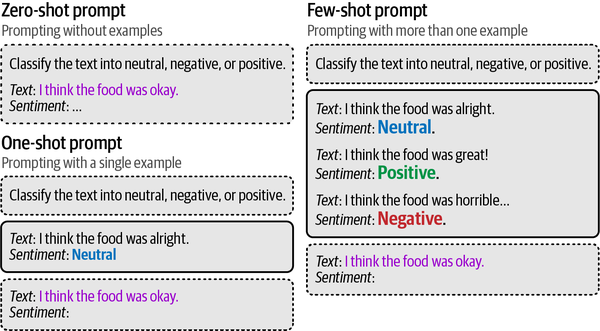

- 零样本提示（zero-shot prompting）不利用示例
- 单样本提示（one-shot prompts）使用一个示例
- 少样本提示（few-shot prompts）使用两个或更多示例

此时，我们需要区分我们的问题（用户）和模型提供的答案（助手）。

In [ ]:
# 在句子中使用这个虚构单词的一个例子
one_shot_prompt = [
    {
        "role": "user",
        "content": "A 'Gigamuru' is a type of Japanese musical instrument. An example of a sentence that uses the word Gigamuru is:"
    },
    {
        "role": "assistant",
        "content": "I have a Gigamuru that my uncle gave me as a gift. I love to play it at home."
    },
    {
        "role": "user",
        "content": "To 'screeg' something is to swing a sword at it. An example of a sentence that uses the word screeg is:"
    }
]
print(tokenizer.apply_chat_template(one_shot_prompt, tokenize=False))

<s><|user|>
A 'Gigamuru' is a type of Japanese musical instrument. An example of a sentence that uses the word Gigamuru is:<|end|>
<|assistant|>
I have a Gigamuru that my uncle gave me as a gift. I love to play it at home.<|end|>
<|user|>
To 'screeg' something is to swing a sword at it. An example of a sentence that uses the word screeg is:<|end|>
<|assistant|>



该提示说明了区分用户和助手的重要性。如果我们不这样做，就会好像我们在自言自语。利用这些交互，我们可以生成如下输出：

In [ ]:
# 生成输出
outputs = pipe(one_shot_prompt)
print(outputs[0]["generated_text"])

 During the intense duel, the knight skillfully screeged his opponent's shield, forcing him to defend himself.


与所有提示组件一样，单样本或少样本提示并不是提示工程的全部。我们可以将其视为拼图中的一块，以进一步增强我们给出的描述。模型仍然可以通过随机抽样“选择”忽略指令。

### 链式提示：分解问题

- 高度复杂的提示或用例，将提示分解为模块化组件的方法可能并不可行

我们不必在单个提示内分解问题，而是可以在提示之间这样做。基本上，我们取一个提示的输出，并将其作为下一个提示的输入，从而创建一个连续的问题解决交互链。

假设我们想要使用LLM根据一系列产品特征为我们创建一个产品名称、口号和销售演讲。虽然我们可以要求LLM一次性完成这些任务，但我们也可以将问题分解成几个部分。

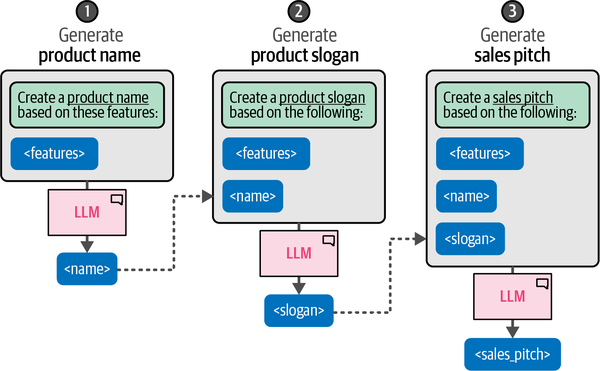

我们得到了一个顺序流程：首先创建产品名称，然后使用产品名称和产品特征作为输入来创建口号，最后使用产品特征、产品名称和口号来创建销售演讲。

这种链式提示技术允许大型语言模型（LLM）在每个问题上投入更多时间，而不是一次性解决整个问题。

In [ ]:
# 为产品创建名称和口号
product_prompt = [
    {"role": "user", "content": "Create a name and slogan for a chatbot that leverages LLMs."}
]
outputs = pipe(product_prompt)
product_description = outputs[0]["generated_text"]
print(product_description)

 Name: "MindMeld Messenger"

Slogan: "Unleashing Intelligent Conversations, One Response at a Time"


In [ ]:
# 基于产品的名称和口号，生成一段销售说辞
sales_prompt = [
    {"role": "user", "content": f"Generate a very short sales pitch for the following product: '{product_description}'"}
]
outputs = pipe(sales_prompt)
sales_pitch = outputs[0]["generated_text"]
print(sales_pitch)

 Introducing MindMeld Messenger - your ultimate communication partner! Unleash intelligent conversations with our innovative AI-powered messaging platform. With MindMeld Messenger, every response is thoughtful, personalized, and timely. Say goodbye to generic replies and hello to meaningful interactions. Elevate your communication game with MindMeld Messenger - where every message is a step towards smarter conversations. Try it now and experience the future of messaging!


这种技术可以应用于多种用例，包括：
- 响应验证：让大型语言模型（LLM）检查之前生成的输出是否正确。
- 并行提示：并行创建多个提示，并进行最后一次合并。例如，让多个LLM并行生成多个食谱，并使用合并后的结果来创建购物清单。
- 编写故事：通过将问题分解为组件，利用LLM来编写书籍或故事。例如，在深入创作对话之前，先写一份概要、发展角色和构建故事节奏。

在下一章中，我们将实现这一过程的自动化，并超越仅仅连接大型语言模型（LLM）的范畴。我们将把其他技术组件也连接起来，比如记忆、工具使用等更多内容！

## 使用生成模型进行推理

- 推理是人类智能的核心组成部分，并且通常与大型语言模型（LLM）所表现出的类似推理的涌现行为进行比较。
- “类似”，因为在撰写本文时，这些模型通常被认为是通过记忆训练数据和模式匹配来展示这种行为的。
- 它们所展示的输出可以表现出复杂的行为，尽管这可能不是“真正”的推理，但仍被称为推理能力。
- 我们的推理方法可以分为系统1和系统2两种思维过程。

系统1思维代表了一种自动、直观且近乎即时的过程。它与生成模型自动生成标记而没有任何自我反思行为的过程相似。

系统2思维是一种有意识、缓慢且逻辑化的过程，类似于头脑风暴和自我反思。

如果我们能让生成模型具备模仿某种自我反思的能力，我们基本上就是在模仿系统2的思维方式，这种思维方式往往能产生比系统1思维更有深度的回应。在本节中，我们将探索几种技术，这些技术试图模仿人类推理者的这些思维过程，旨在改进模型的输出。

### 思维链：先思考后回答

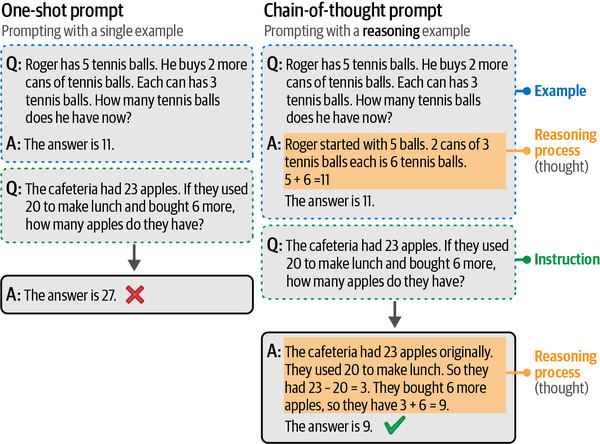

如图所示，它在提示中提供了示例，展示了模型在生成回答之前应该进行的推理。这些推理过程被称为“思维”。这对于涉及更高复杂度的任务（如数学问题）来说非常有帮助。增加这一推理步骤可以使模型在计算过程中分配更多的算力。

In [ ]:
# 使用思维链进行回答
cot_prompt = [
    {"role": "user", "content": "Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?"},
    {"role": "assistant", "content": "Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. 5 + 6 = 11. The answer is 11."},
    {"role": "user", "content": "The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?"}
]

# 生成输出
outputs = pipe(cot_prompt)
print(outputs[0]["generated_text"])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


 The cafeteria started with 23 apples. They used 20 apples, so they had 23 - 20 = 3 apples left. Then they bought 6 more apples, so they now have 3 + 6 = 9 apples. The answer is 9.


尽管思维链是增强生成模型输出的一个很好方法，但它确实需要在提示中包含一个或多个推理示例，而用户可能无法获得这些示例。我们可以不必提供示例，而是简单地要求生成模型提供推理（零样本思维链），一种常见且有效的方法是使用短语“让我们一步一步思考”。

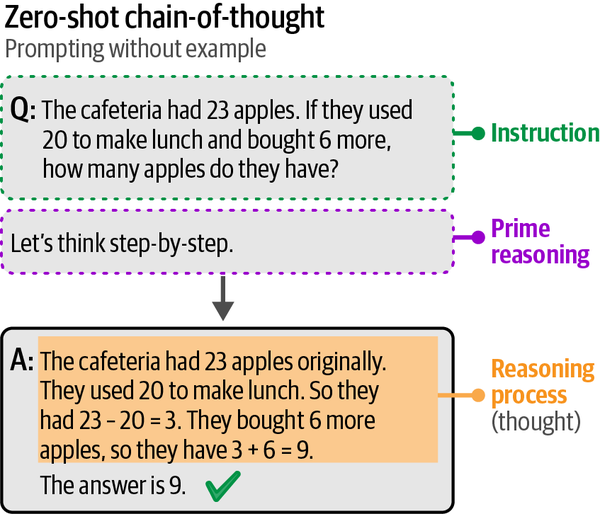

In [ ]:
# 零样本思维链
zeroshot_cot_prompt = [
    {"role": "user", "content": "The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have? Let's think step-by-step."}
]

# 生成输出
outputs = pipe(zeroshot_cot_prompt)
print(outputs[0]["generated_text"])

 Step 1: Start with the initial number of apples, which is 23.
Step 2: Subtract the number of apples used to make lunch, which is 20. So, 23 - 20 = 3 apples remaining.
Step 3: Add the number of apples bought, which is 6. So, 3 + 6 = 9 apples.

The cafeteria now has 9 apples.


无需提供示例，我们再次获得了相同的推理行为。通过解决推理过程，大型语言模型（LLM）可以使用之前生成的信息作为生成最终答案的指南。

### 自洽性：采样输出

- 通过temperature和top_p等参数来体现一定程度的创造性，那么使用相同的提示多次可能会产生不同的结果。因此，输出的质量可能会因标记的随机选择而提高或降低。
- 自洽性方法：要求生成模型多次接收相同的提示，并将大多数结果作为最终答案。

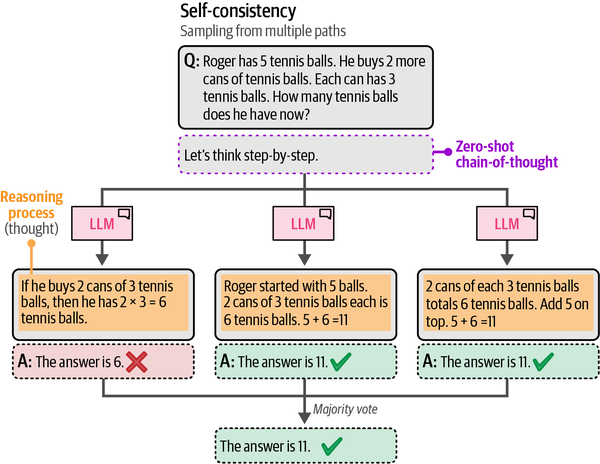

然而，这确实需要多次询问同一个问题。因此，虽然该方法可以提高性能，但其速度会减慢n倍，其中n为输出样本的数量。

### 思维树：探索中间步骤

- 思维链和自洽性的理念旨在实现更复杂的推理。通过从多个“思维”中进行采样并使其更具思考性。
- 思维树提供了一个改进方案，它允许对多个想法进行深入的探索。

当面临一个需要多个推理步骤的问题时，将其分解成几个部分通常很有帮助。在每个步骤中，会提示生成模型探索当前问题的不同解决方案。然后，它会对最佳解决方案进行投票，并继续下一步。

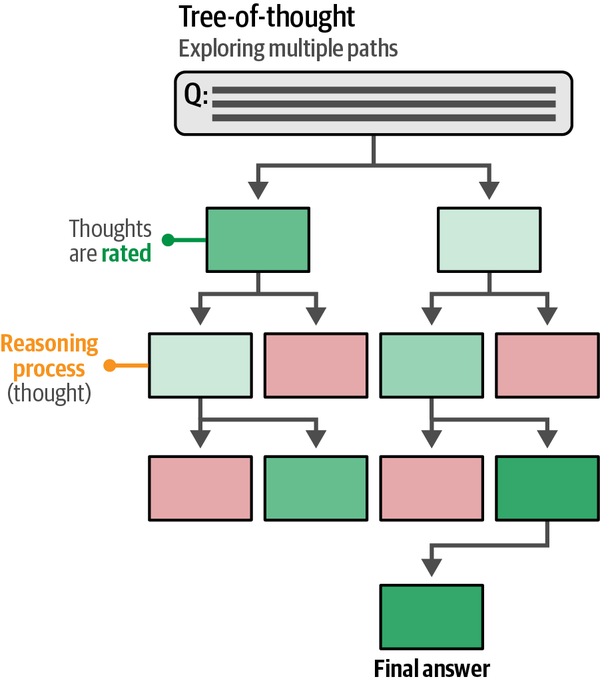

当需要考虑多条路径时，比如写故事或提出创意想法时，这种方法非常有帮助。这种方法的缺点是它需要多次调用生成模型，这显著降低了应用程序的速度。幸运的是，已经成功尝试将思维树框架转化为一种简单的提示技术。我们不再多次调用生成模型，而是要求模型通过模拟多位专家之间的对话来模仿这种行为。这些专家会相互提问，直到达成共识。

In [ ]:
# Zero-shot Chain-of-Thought
zeroshot_tot_prompt = [
    {"role": "user", "content": "Imagine three different experts are answering this question. All experts will write down 1 step of their thinking, then share it with the group. Then all experts will go on to the next step, etc. If any expert realises they're wrong at any point then they leave. The question is 'The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?' Make sure to discuss the results."}
]

In [ ]:
# Generate the output
outputs = pipe(zeroshot_tot_prompt)
print(outputs[0]["generated_text"])

 Expert 1: Step 1 - Start with the initial number of apples: 23 apples.

Expert 2: Step 1 - Subtract the apples used for lunch: 23 - 20 = 3 apples remaining.

Expert 3: Step 1 - Add the newly bought apples: 3 + 6 = 9 apples.


Expert 1: Step 2 - Confirm the final count: The cafeteria has 9 apples.

Expert 2: Step 2 - Review the calculations: 23 - 20 = 3, then 3 + 6 = 9. The calculations are correct.

Expert 3: Step 2 - Agree with the result: The cafeteria indeed has 9 apples.


All experts agree on the final count: The cafeteria has 9 apples.


## 输出验证

- 结构化输出：默认情况下，大多数生成模型创建的是自由形式的文本，除了自然语言定义的结构外，不遵循其他特定结构。某些用例要求其输出以特定格式（如JSON）结构化。
- 有效输出：即使我们允许模型生成结构化输出，它仍然具有自由生成内容的能力。例如，当要求模型输出两个选项中的一个时，它不应提出第三个选项。
- 道德伦理：一些开源生成模型没有防护栏，会生成不考虑安全或道德因素的输出。例如，用例可能要求输出中不包含粗俗语言、个人身份信息（PII）、偏见、文化刻板印象等。
- 准确性：许多用例要求输出符合特定标准或性能。目的是双重检查生成的信息是否事实准确、连贯或没有幻觉（即不基于事实的错误信息）。

通常，控制生成模型输出的方法有三种：
- 示例：提供一系列预期输出的示例。
- 语法：控制标记选择过程。
- 微调：在包含预期输出的数据上对模型进行微调。

### 提供示例

- 小样本学习是一种有助于引导生成模型输出的技术，这种方法同样可以推广应用于引导输出的结构。

我们希望生成模型为角色扮演游戏（RPG）创建一个角色档案。我们首先不使用任何示例：

In [ ]:
# Zero-shot learning: Providing no examples
zeroshot_prompt = [
    {"role": "user", "content": "Create a character profile for an RPG game in JSON format."}
]

# Generate the output
outputs = pipe(zeroshot_prompt)
print(outputs[0]["generated_text"])

 {
  "character_profile": {
    "name": "Eldrin Stormbringer",
    "race": "Human",
    "class": "Warlock",
    "level": 5,
    "alignment": "Chaotic Good",
    "attributes": {
      "strength": 8,
      "dexterity": 14,
      "constitution": 10,
      "intelligence": 12,
      "wisdom": 10,
      "charisma": 16
    },
    "skills": [
      {
        "name": "Fireball",
        "proficiency": 18
      },
      {
        "name": "Shadowstep",
        "proficiency": 16
      },
      {
        "name": "Charm Person",
        "proficiency": 14
      }
    ],
    "equipment": [
      {
        "name": "Stormbringer Staff",
        "type": "Magic Weapon",
        "damage": 15
      },
      {
        "name": "Leather Armor",
        "type": "Light Armor",
        "defense": 10
      },
      {
        "name": "Ring of Protection",
        "type": "Magic Armor",
        "defense": 5
      }
    ],
    "background": "Eldrin grew up in a small village, where he was known for his mischievous na

前面的截断输出不是有效的JSON，因为模型在开始生成“charisma”属性后就停止了生成令牌。此外，我们可能并不需要某些属性。相反，我们可以向模型提供一些示例，以指示所需的格式：

In [ ]:
# One-shot learning: Providing an example of the output structure
one_shot_template = """Create a short character profile for an RPG game. Make sure to only use this format:

{
  "description": "A SHORT DESCRIPTION",
  "name": "THE CHARACTER'S NAME",
  "armor": "ONE PIECE OF ARMOR",
  "weapon": "ONE OR MORE WEAPONS"
}
"""
one_shot_prompt = [
    {"role": "user", "content": one_shot_template}
]

# Generate the output
outputs = pipe(one_shot_prompt)
print(outputs[0]["generated_text"])

 {
  "description": "A cunning rogue with a mysterious past, skilled in stealth and deception.",
  "name": "Lysandra Shadowstep",
  "armor": "Leather Cloak of the Night",
  "weapon": "Dagger of Whispers, Throwing Knives"
}


### 语法：约束采样

- 少样本学习有一个很大的缺点：我们无法明确阻止某些输出的生成。
- 为了约束和验证生成模型的输出，已经迅速开发出了许多软件包，如Guidance（指导）、Guardrails（护栏）和LMQL等。

使用大型语言模型（LLM）来检查输出是否正确遵循了我们的规则。

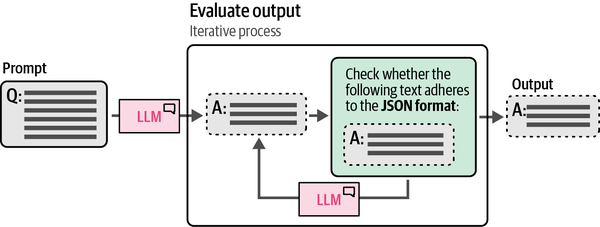

这个验证过程也可以用来控制输出的格式，因为我们已经知道它应该如何结构化，所以我们可以自己生成其格式的一部分。使用大型语言模型（LLM）仅生成我们事先不知道的信息片段。

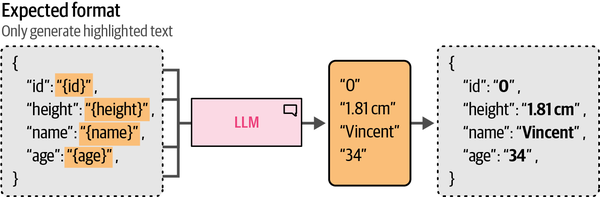

这个过程可以更进一步，我们不必在输出后进行验证，而是可以在令牌采样过程中直接进行验证。在采样令牌时，我们可以定义一系列语法或规则，要求LLM在选择下一个令牌时必须遵守。

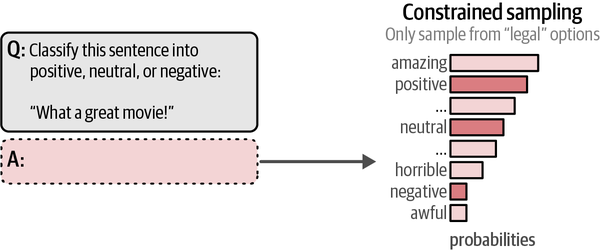

让我们使用llama-cpp-python这个库来举例说明这个现象，它与transformers库类似，可以用来加载我们的语言模型。

In [ ]:
import gc
import torch
del model, tokenizer, pipe

# 清空内存
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from llama_cpp.llama import Llama

# Load Phi-3
llm = Llama.from_pretrained(
    repo_id="microsoft/Phi-3-mini-4k-instruct-gguf",  # 存放模型的Hugging Face仓库的位置
    filename="*fp16.gguf",
    n_gpu_layers=-1,  # 希望模型的所有层都在GPU上运行
    n_ctx=2048,  # 模型的上下文大小
    verbose=False
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Generate output
output = llm.create_chat_completion(
    messages=[
        {"role": "user", "content": "Create a warrior for an RPG in JSON format."},
    ],
    response_format={"type": "json_object"},  # 使用内部JSON语法生成输出
    temperature=0,
)['choices'][0]['message']["content"]


In [ ]:
import json

# Format as json
json_output = json.dumps(json.loads(output), indent=4)
print(json_output)

{
    "name": "Eldrin Stormbringer",
    "class": "Ranger",
    "level": 5,
    "attributes": {
        "strength": 14,
        "dexterity": 18,
        "constitution": 12,
        "intelligence": 10,
        "wisdom": 13,
        "charisma": 9
    },
    "skills": {
        "archery": {
            "proficiency": 20,
            "critical_hit_chance": 5,
            "damage_range": [
                8,
                14
            ]
        },
        "stealth": {
            "proficiency": 17,
            "critical_hit_chance": 3,
            "damage_range": [
                2,
                6
            ]
        },
        "nature_magic": {
            "proficiency": 15,
            "critical_hit_chance": 4,
            "healing_range": [
                3,
                7
            ],
            "damage_range": [
                -2,
                2
            ]
        }
    },
    "equipment": {
        "weapons": [
            "Longbow",
            "Dagger"
      

## 总结

在本章中，我们探讨了通过提示工程和输出验证来使用生成模型的基础知识。
- 我们重点关注了提示工程所带来的创造性和潜在复杂性。这些提示的组成部分对于生成和优化适合不同用例的输出至关重要。
- 我们还进一步探索了高级提示工程技术，如上下文学习和思维链。这些方法涉及通过提供鼓励逐步思考的示例或短语来引导生成模型解决复杂问题，从而模仿人类的推理过程。

总体而言，本章表明，提示工程是与大型语言模型（LLMs）合作的关键方面，因为它使我们能够有效地向模型传达我们的需求和偏好。通过掌握提示工程技术，我们可以释放LLMs的一些潜力，并生成符合我们要求的高质量回复。